# Simulation on Dynamic Tensor

In [1]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

%matplotlib inline
sns.set_theme()

torch.manual_seed(42)
np.random.seed(123)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

## Generate Data

In [2]:
I = 4

SIG = 2.0
u = np.random.multivariate_normal(np.array([0, 2]), SIG * np.eye(2), size= 2 * I)
v = np.random.multivariate_normal(np.array([1, 1]), SIG * np.eye(2), size= 2 * I)

In [3]:
T = 200

tensor = []
time = np.linspace(0, 1, T)
for t in range(T):
    foo = np.zeros([2 * I, 2 * I])
    t_ = time[t]
    for i in range(2 * I):
        for j in range(2 * I):
            foo[i, j] = u[i, 0] * v[j, 0] * np.sin(2 * np.pi * t_) + \
                u[i, 0] * v[j, 1] * np.cos(2 * np.pi * t_) + \
                u[i, 1] * v[j, 0] * np.sin(2 * np.pi * t_) ** 2 + \
                u[i, 1] * v[j, 1] * np.cos(5 * np.pi * t_) * np.sin(5 * np.pi * t_) ** 2
                # u[i, 1] * v[j, 1] * np.cos(2 * np.pi * t_) * np.sin(2 * np.pi * t_) ** 2
    tensor.append(foo)
tensor = np.stack(tensor, -1)
# tensor /= 4
tensor -= tensor.min(-1, keepdims=True)
tensor /= tensor.max(-1, keepdims=True)
tensor *= 2.
print(tensor.min())
print(tensor.max())

0.0
2.0


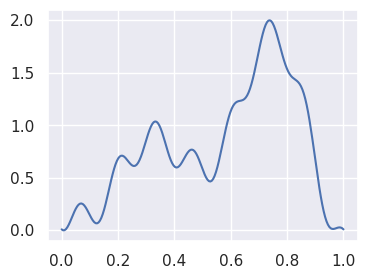

In [4]:
plt.figure(figsize=(4, 3))
plt.plot(time, tensor[0, 1, :])

(0.0, 1.0)

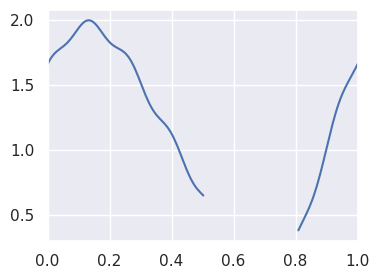

In [5]:
MR = 0.3

mask = np.ones([2 * I, 2 * I, T])
if MR != 0.:
    assert MR > 0
    for i in range(2 * I):
        for j in range(2 * I):
            start_id = np.random.randint(0, int((1 - float(MR)) * T))
            mask[i, j, start_id:start_id + int(float(MR) * T)] = 0


plt.figure(figsize=(4, 3))

tensor_obs = tensor * mask
tensor_obs[mask == 0.] = np.nan
plt.plot(time, tensor_obs[1, 1, :])
plt.xlim([0., 1.])

In [6]:
BATCH_SIZE = 1000

tensor = torch.tensor(tensor, dtype=torch.float32).to(DEVICE)
mask = torch.tensor(mask, dtype=torch.float32).to(DEVICE)
time = torch.tensor(time, dtype=torch.float32).to(DEVICE)

train_idx = torch.nonzero(mask, as_tuple=True)
train_val = tensor[train_idx]
train_idx = torch.stack(train_idx).T
train_dt = TensorDataset(train_idx, train_val)
train_loader = DataLoader(train_dt, batch_size=BATCH_SIZE, shuffle=True)
print(train_dt.tensors[0].shape)

torch.Size([8960, 3])


## Model

In [7]:
from src.model import EnergyTDTime


class Trainer:
    """docstring for Trainer."""
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        epoch=500,
        eval_interval=10,
        print_eval=True
    ):
        super(Trainer, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epoch = epoch

        self.eval_interval = eval_interval
        self.print_eval = print_eval

        self.current_epoch = 0
        self.loss_log = {'train': [], 'test': [], 'val': []}

    def train(self, train_loader, valid_loader=None, test_loader=None):
        bar = tqdm(range(self.epoch), desc='[Epoch 0]')
        for epoch in bar:
            bar.set_description(f'[Epoch {epoch}]')
            self.train_epoch(train_loader)
            if valid_loader is not None:
                self.eval_epoch(valid_loader, 'Valid')
            if test_loader is not None:
                self.eval_epoch(test_loader, 'Test')
            self.current_epoch += 1
            self.scheduler.step()

            bar.set_postfix({'Loss': self.current_loss})

    def train_epoch(self, data_loader):
        model = self.model

        model.train()

        loss_log = []
        for batch_idx, (inputs, x_val) in enumerate(data_loader):
            inputs = inputs.to(DEVICE)
            x_val = x_val.to(DEVICE)
            x_val += torch.randn_like(x_val) * DATA_NOISE
            time_stamp = time[inputs[:, -1]].to(DEVICE)
            inputs = inputs[:, :2]

            vnce = model.loss(inputs, time_stamp, x_val)
            loss = - vnce

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            loss_log.append(vnce.item())

        loss_log = np.mean(loss_log)
        self.current_loss = loss_log
        self.loss_log['train'].append(loss_log)

In [ ]:
RANK = 3
H_DIM = [64] * 3
ACT = 'elu'
NOISE_SIGMA = 1.
NU = 20
DATA_NOISE = 0.0

EPOCH = 500
LR = 1e-3

model = EnergyTDTime(
    tensor_shape=[2 * I, 2 * I],
    rank=RANK,
    h_dim=H_DIM,
    act=ACT,
    nu=NU,
    noise_sigma=NOISE_SIGMA,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
miles = [int(i * EPOCH) for i in (0.6, 0.9)]
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer, milestones=miles, gamma=0.3
)
trainer = Trainer(
    model=model, optimizer=optimizer, scheduler=scheduler, epoch=EPOCH
)
trainer.train(train_loader)

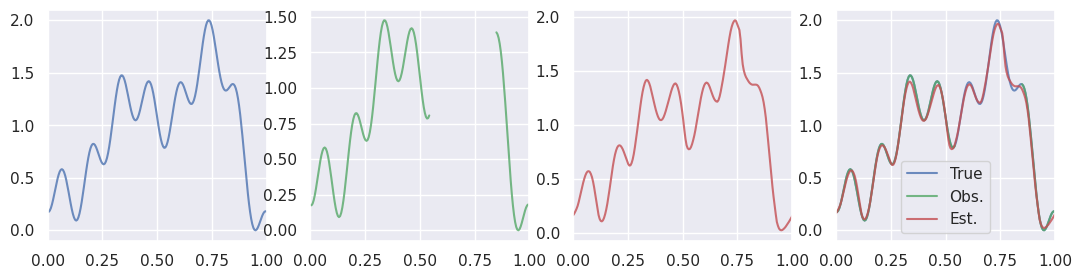

In [9]:
GRID = 1e-3
IDX1 = 0
IDX2 = 2

model = trainer.model
model.train()

idx = torch.tensor([IDX1, IDX2], dtype=torch.int64, device=DEVICE).view(1, -1).repeat(T, 1)
with torch.no_grad():
    x_hat = model.predict(idx, time, x_range=[-0.5, 2.5], epsilon=GRID).view(-1)

plt.figure(figsize=(13, 3))
plt.subplot(141)
plt.plot(time.cpu().numpy(), tensor[IDX1, IDX2, :].cpu().numpy(), color='b', alpha=0.8, label='True')
plt.xlim([0., 1.])
# plt.ylim([0., 1.])

plt.subplot(142)
plt.plot(time.cpu().numpy(), tensor_obs[IDX1, IDX2, :], color='g', alpha=0.8, label='Obs.')
plt.xlim([0., 1.])
# plt.ylim([0., 1.])

plt.subplot(143)
plt.plot(time.cpu().numpy(), x_hat.cpu().numpy(), color='r', alpha=0.8, label='Est.')
plt.xlim([0., 1.])
# plt.ylim([0., 1.])

plt.subplot(144)
plt.plot(time.cpu().numpy(), tensor[IDX1, IDX2, :].cpu().numpy(), color='b', alpha=0.8, label='True')
plt.plot(time.cpu().numpy(), tensor_obs[IDX1, IDX2, :], color='g', alpha=0.8, label='Obs.')
plt.plot(time.cpu().numpy(), x_hat.cpu().numpy(), color='r', alpha=0.8, label='Est.')
plt.xlim([0., 1.])

plt.legend()
